<a href="https://colab.research.google.com/github/MosaicGroupCMU/African-MRS-Tutorials/blob/main/Google-Colab/Quantum_Espresso_H2O.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to geometry optimization of molecular water using Quantum ESPRESSO

Contributors: [Seda Oturak](https://github.com/sedaoturak), [Ismaila Dabo](https://scholar.google.com/citations?user=rN299m0AAAAJ&hl=en), [Jessica Wen](https://github.com/JessicaWen-PhD), [Cierra Chandler](https://github.com/Cierra-Chandler), [Henry Eya](https://github.com/Henrynweya)



# Install libraries, environment, and Quantum ESPRESSO

This part installs libraries for numerical calculations and plotting.

In [ ]:
# load plotting libraries
import matplotlib.pyplot as plt

# load numerical libraries
import numpy as np

Quantum ESPRESSO is a plane wave code, which uses Fourier transforms to solve equations in plane wave space. This part installs libraries for fast Fourier transforms (FFTs).

In [ ]:
# eliminate text output during installation
%%capture

# install mathematical libraries to peform fast Fourier transforms
# (the exclamation mark means that the command is run under Linux)
! apt-get install -y libfftw3-3 libfftw3-dev libfftw3-doc

The Atomic Simulation Environment (ASE) is a set of tools for running, visualizing, and analyzing simulations. This part installs ASE.

In [ ]:
# eliminate text output during installation
%%capture

# install the Atomic simulation environment
# ! apt install ase
! pip install git+https://gitlab.com/ase/ase

Compiling Quantum ESPRESSO from scratch would take a long time. This part uploads pre-compiled executable files (`.x` extension) and additional files containing the pseudopotentials.

In [ ]:
# eliminate text output during installation
%%capture

# navigate to main directory named '/content/'
%cd /content/

# download the pre-compiled files in compressed format (under Linux)
! wget 'https://docs.google.com/uc?export=download&id=1kw_CJMjP6ggDZXDNp5phAqCPpoe2WXCA' -O qe-lite.tgz

# unpack the compressed files (under Linux)
! tar -xvzf qe-lite.tgz

# clean up some files
! rm -rf sample_data qe-lite.tgz

# Prepare Quantum ESPRESSO input file

The calculation is for a water molecule. The definition of the input parameters of the `pw.x` executable can be found at `www.quantum-espresso.org/Doc/INPUT_PW.html`.

In [ ]:
# create calculation folder and navigate into it
%mkdir -p /content/water
%cd /content/water/

# create input and write it into the file h20.scf.in
qe_input = """
&control
  prefix='water',
  pseudo_dir = '/content/qe-lite/pseudopotentials',
  outdir='/content/water'
/
&system
  ibrav = 0,
  nat = 3,
  ntyp = 2,
  ecutwfc = 30.0,
  ecutrho = 240.0,
  occupations  = 'smearing'
  degauss      = 0.001
  smearing     = 'marzari-vanderbilt'
/
&electrons
  conv_thr = 1e-8,
/
ATOMIC_SPECIES
O 15.999 O.UPF
H 1.008 H.UPF

K_POINTS automatic
1 1 1 0 0 0

CELL_PARAMETERS angstrom
10.00000000000000 0.00000000000000 0.00000000000000
0.00000000000000 10.00000000000000 0.00000000000000
0.00000000000000 0.00000000000000 10.00000000000000

ATOMIC_POSITIONS angstrom
O 0.0000000000 0.0000000000 0.2981545000
H 0.0000000000 0.7632390000 -0.2981545000
H 0.0000000000 -0.7632390000 -0.2981545000

"""

with open("h20.scf.in", "w") as f:
    f.write(qe_input)

# print the content of the input file (under Linux)
! cat h20.scf.in

/content/water

&control
  prefix='water',
  pseudo_dir = '/content/qe-lite/pseudopotentials',
  outdir='/content/water'
/
&system
  ibrav = 0,
  nat = 3,
  ntyp = 2,
  ecutwfc = 30.0,
  ecutrho = 240.0,
  occupations  = 'smearing'
  degauss      = 0.001
  smearing     = 'marzari-vanderbilt'
/
&electrons
  conv_thr = 1e-8,
/
ATOMIC_SPECIES
O 15.999 O.UPF
H 1.008 H.UPF

K_POINTS automatic
1 1 1 0 0 0

CELL_PARAMETERS angstrom
10.00000000000000 0.00000000000000 0.00000000000000
0.00000000000000 10.00000000000000 0.00000000000000
0.00000000000000 0.00000000000000 10.00000000000000

ATOMIC_POSITIONS angstrom
O 0.0000000000 0.0000000000 0.2981545000
H 0.0000000000 0.7632390000 -0.2981545000
H 0.0000000000 -0.7632390000 -0.2981545000



Use ASE tools to extract information from Quantum ESPRESSO input and visualize the crystal.

In [ ]:
import ase.io.espresso
from ase import Atoms
from ase.visualize import view
from ase.build import make_supercell
from ase.build import bulk

# extract unit cell information from input file using ASE
input_file = ase.io.espresso.read_espresso_in('h20.scf.in')
water = Atoms(input_file)

# create a supercell (3 × 3 × 3) using ASE
multiplier = np.identity(3) * 3
water_supercell = make_supercell(water,multiplier)

# visualize the supercell
view(water_supercell, viewer='x3d')

# Run Quantum ESPRESSO using input file

In [ ]:
# run the pw.x executable using si.scf.in to create si.scf.out
! /content/qe-lite/bin/pw.x < h20.scf.in > h20.scf.out

# print the content of the output file (under Linux)
! cat h20.scf.out


     Program PWSCF v.7.4 starts on  4Dec2024 at 15:50:56 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     8945 MiB available memory on the printing compute node when the environment starts

     Waiting for input...
     Reading input from standard input

     Current dimensions of program PWSCF are:
     Max number of different atomic species (ntypx) = 10
     Max number of k-points (npk) =  40000
     Max angular momentum in pseudopotentials (lmaxx) =  4
     Message from routine setup:
     using ibrav=0 wi

In [ ]:
# first method: extract total energies in rydberg during the self-consistent-field calculation (under Linux)
! grep -e "total energy  " -e "estimated" h20.scf.out

     total energy              =     -34.46638195 Ry
     estimated scf accuracy    <       0.45980759 Ry
     total energy              =     -34.57693590 Ry
     estimated scf accuracy    <       0.43521711 Ry
     total energy              =     -34.65647122 Ry
     estimated scf accuracy    <       0.00394257 Ry
     total energy              =     -34.65736206 Ry
     estimated scf accuracy    <       0.00137293 Ry
     total energy              =     -34.65726977 Ry
     estimated scf accuracy    <       0.00025543 Ry
     total energy              =     -34.65733619 Ry
     estimated scf accuracy    <       0.00002315 Ry
     total energy              =     -34.65734146 Ry
     estimated scf accuracy    <       0.00000278 Ry
     total energy              =     -34.65734191 Ry
     estimated scf accuracy    <       0.00000012 Ry
     total energy              =     -34.65734191 Ry
     estimated scf accuracy    <       0.00000001 Ry
!    total energy              =     -34.65734

In [ ]:
# define physical constants for unit conversion
from scipy.constants import physical_constants
ha_in_ev = physical_constants["Hartree energy in eV"][0]
ry_in_ev = ha_in_ev / 2.

# second method: extract total energy at the end of the self-consistent calculation (using ASE)
output = ase.io.read("/content/water/h20.scf.out")
total_energy = output.get_total_energy()
print("Energy = %.8f Ry " % total_energy)
print("Energy = %.8f eV " % ( total_energy / ry_in_ev ) )

Energy = -471.53711737 Ry 
Energy = -34.65733889 eV 


# Convergence test with respect to the cutoff energy


In [ ]:
# create a list for cutoff energies to be tested
cutoff_energies = np.arange(12,44,4)

# find the "cutoff energy" line in the input file
wfc_index = qe_input.find('ecutwfc = ') + 10
rho_index = qe_input.find('ecutrho = ') + 10

total_energies = [[],[],[]]
for (n, cutoff_ratio) in enumerate([4,8,10]):
  for cutoff in cutoff_energies:
    # update the input file with the new cutoff energy
    new_input_file = ( qe_input[:wfc_index] + str(cutoff) + qe_input[wfc_index+4:rho_index]
                     + str(cutoff * cutoff_ratio) + qe_input[rho_index+5:] )

    # overwrite the input file
    with open("si.scf.in", "w") as f:
      f.write(new_input_file)

    ! cat si.scf.in
    ! /content/qe-lite/bin/pw.x  < si.scf.in > si.scf.out # run the DFT input file

    output = ase.io.read("/content/silicon/si.scf.out") # read the output file

    total_energies[n].append(output.get_total_energy()) # record the calculated total energy

In [ ]:
# plot convergence graph
fig,ax = plt.subplots()
ax.plot(cutoff_energies, np.transpose(total_energies),'o-')
ax.legend(['4','8','10'])
ax.set_xlabel('Cutoff Energies (eV)')
ax.set_ylabel('Total Energy (eV/atom)')
# magnify the y-axis
# plt.ylim([-310.74,-310.72])
plt.show()

# Convergence test with respect to the k-point sampling

In [ ]:
# initialize input file with appropriate cutoffs
qe_input = """
&control
  prefix='silicon',
  pseudo_dir = '/content/qe-lite/pseudopotentials',
  outdir='/content/silicon/'
/
&system
  ibrav = 0,
  celldm(1) = 10.2,
  nat = 2,
  ntyp = 1,
  ecutwfc = 30.0,
  ecutrho = 240.0,
/
&electrons
  conv_thr = 1e-8,
/
ATOMIC_SPECIES
 Si  28.086  Si.UPF
ATOMIC_POSITIONS alat
 Si 0.00 0.00 0.00
 Si 0.25 0.25 0.25
K_POINTS automatic
   4 4 4 1 1 1
CELL_PARAMETERS
  0.0 0.5 0.5
  0.5 0.0 0.5
  0.5 0.5 0.0
"""

with open("si.scf.in", "w") as f:
    f.write(qe_input)

# print the content of the input file (under Linux)
! cat si.scf.in

# create a list for k points to be tested
kpoints = np.arange(1,9,1) # enter kpoints limits
# find the "lattice constant" line in the input file
lat_cons_index = qe_input.find('K_POINTS') + 20

total_energies = []

for k in kpoints:
  # update the input file with the new lattice constant
  new_input_file = qe_input[:lat_cons_index] + str(k).ljust(2) + str(k).ljust(2) + str(k).ljust(2) + qe_input[lat_cons_index+8:]

  # overwrite the input file
  with open("si.scf.in", "w") as f:
    f.write(new_input_file)

  ! cat si.scf.in
  ! /content/qe-lite/bin/pw.x  -in si.scf.in > si.scf.out # run the DFT input file

  output = ase.io.read("/content/silicon/si.scf.out") # read the output file

  total_energies.append(output.get_total_energy()) # record the calculated total energy

In [ ]:
# plot convergence graph
fig,ax = plt.subplots()
ax.plot(kpoints, total_energies,'o-')
ax.set_xlabel('Sampling')
ax.set_ylabel('Total Energy (eV)')
# magnify the y-axis
# plt.ylim([-310.74,-310.73])
plt.show()

# Lattice parameter

In [ ]:
# initialize input file with appropriate cutoffs and k-point sampling
qe_input = """
&control
  prefix='silicon',
  pseudo_dir = '/content/qe-lite/pseudopotentials',
  outdir='/content/silicon/'
/
&system
  ibrav = 0,
  celldm(1) = 10.2,
  nat = 2,
  ntyp = 1,
  ecutwfc = 30.0,
  ecutrho = 240.0,
/
&electrons
  conv_thr = 1e-8,
/
ATOMIC_SPECIES
 Si  28.086  Si.UPF
ATOMIC_POSITIONS alat
 Si 0.00 0.00 0.00
 Si 0.25 0.25 0.25
K_POINTS automatic
   5 5 5 1 1 1
CELL_PARAMETERS
  0.0 0.5 0.5
  0.5 0.0 0.5
  0.5 0.5 0.0
"""

with open("si.scf.in", "w") as f:
    f.write(qe_input)

# print the content of the input file (under Linux)
! cat si.scf.in

# create a list for lattice constants to be tested
lattice_constants = np.arange(9.5,11.1,0.1)

# find the "lattice constant" line in the input file
lat_cons_index = qe_input.find('celldm(1) =') + 11

total_energies = []
for constant in lattice_constants:
  # update the input file with the new lattice constant
  new_input_file = qe_input[:lat_cons_index] + " %.2f" % constant + qe_input[lat_cons_index+5:]

  # overwrite the input file
  with open("si.scf.in", "w") as f:
    f.write(new_input_file)

  ! cat si.scf.in
  ! /content/qe-lite/bin/pw.x  -in si.scf.in > si.scf.out # run the DFT input file

  output = ase.io.read("/content/silicon/si.scf.out") # read the output file

  total_energies.append(output.get_total_energy()) # record the calculated total energy


&control
  prefix='silicon',
  pseudo_dir = '/content/qe-lite/pseudopotentials',
  outdir='/content/silicon/'
/
&system
  ibrav = 0,
  celldm(1) = 10.2,
  nat = 2,
  ntyp = 1,
  ecutwfc = 30.0,
  ecutrho = 240.0,
/
&electrons
  conv_thr = 1e-8,
/
ATOMIC_SPECIES
 Si  28.086  Si.UPF
ATOMIC_POSITIONS alat
 Si 0.00 0.00 0.00
 Si 0.25 0.25 0.25
K_POINTS automatic
   5 5 5 1 1 1
CELL_PARAMETERS
  0.0 0.5 0.5
  0.5 0.0 0.5
  0.5 0.5 0.0

&control
  prefix='silicon',
  pseudo_dir = '/content/qe-lite/pseudopotentials',
  outdir='/content/silicon/'
/
&system
  ibrav = 0,
  celldm(1) = 9.50,
  nat = 2,
  ntyp = 1,
  ecutwfc = 30.0,
  ecutrho = 240.0,
/
&electrons
  conv_thr = 1e-8,
/
ATOMIC_SPECIES
 Si  28.086  Si.UPF
ATOMIC_POSITIONS alat
 Si 0.00 0.00 0.00
 Si 0.25 0.25 0.25
K_POINTS automatic
   5 5 5 1 1 1
CELL_PARAMETERS
  0.0 0.5 0.5
  0.5 0.0 0.5
  0.5 0.5 0.0

&control
  prefix='silicon',
  pseudo_dir = '/content/qe-lite/pseudopotentials',
  outdir='/content/silicon/'
/
&system
  ibrav =

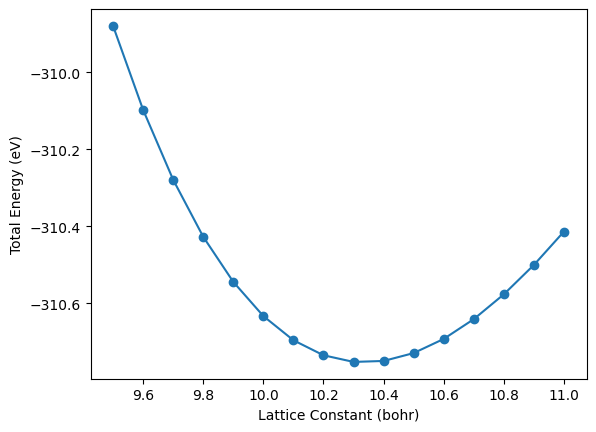

In [ ]:
# plot potential energy curve
fig,ax = plt.subplots()
ax.plot(lattice_constants, total_energies,'o-')
ax.set_xlabel('Lattice Constant (bohr)')
ax.set_ylabel('Total Energy (eV)')
plt.show()